In [18]:
###
###  Test shifting waveform
###  
import numpy as np
y=[100]*7
x=[1,2,3,4,5,6,7]

a=-3
MAX=len(x)
y[max(0,a):min(MAX, MAX+a)] += np.roll(x, a)[max(0,a):min(MAX, MAX+a)]
print (y)

[104, 105, 106, 107, 100, 100, 100]


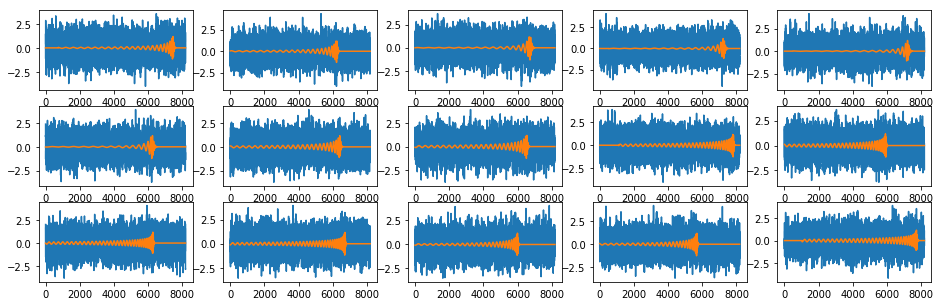

In [12]:
###
###  Prepare data: extract, transform, load (ETL)
###
import h5py as h5
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
    
import os
import time
from datetime import datetime

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

LABLE_WIDTH = 1
X_FEATURE = 'x'  # Name of the input feature.

RATE = 8192

#FLAGS = tf.app.flags.FLAGS
#tf.app.flags.DEFINE_string("train_data_path", "/home/yongcai/chinese_fenci/train.txt", "training data dir")
#tf.app.flags.DEFINE_string("log_dir", "./logs", " the log dir")
#tf.app.flags.DEFINE_integer("max_sentence_len", 80, "max num of tokens per query")
#tf.app.flags.DEFINE_integer("shuffle_buffer_size", )

class GWInject():
    def _shift_noise(self, tag, A, shift):
        var = self.f[tag]
        swf = np.zeros(var.shape)  ## shifted template 
        NX = len(var)
        X = ( np.random.normal(0,1,var.shape)).astype(np.float32)
        MAX=self.srate
        for i in range(NX):
            a = int((np.random.random()-0.5)*shift)  ## shift left or right
            swf[i,max(0,a):min(MAX, MAX+a)] += A * np.roll(var[i], a)[max(0,a):min(MAX, MAX+a)]
            
        X = (A * swf[:NX,:] + np.random.normal(0,1,var.shape)).astype(np.float32)
        Y = np.ones(NX)
        NN = NX
        X  = np.vstack( (X, np.random.normal(0,1,(NX,self.srate))  )         ) .astype(np.float32)
        Y  = np.hstack( (Y, np.zeros(NN) )                          ).astype(np.float32).reshape(-1,1)
        
        if self.plot:
            plt.figure(figsize=(16,5))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)
                plt.plot(X[i,:])
                plt.plot(swf[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        return X, Y
    def _add_noise(self, tag, A):
        var = self.f[tag]
        NX = len(var)
        X = (A * var[:NX,:] + np.random.normal(0,1,(NX,self.srate))).astype(np.float32)
        #X = (A * var[:NX,:] + (np.random.random((NX,self.srate))-0.5 )*2  ).astype(np.float32)
        Y = np.ones(NX)
        NN = NX
        X  = np.vstack( (X, np.random.normal(0,1,(NX,self.srate))  )         ) .astype(np.float32)
        #X  = np.vstack( (X, (np.random.random((NX,self.srate))-0.5 )*2  )    ) .astype(np.float32)
        Y  = np.hstack( (Y, np.zeros(NN) )                          ).astype(np.float32).reshape(-1,1)
        
        if self.plot:
            plt.figure(figsize=(16,5))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)
                plt.plot(X[i,:])
                plt.plot(A * var[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        return X, Y
    def __init__(self, fname, plot=0):
        self.fname = fname
        self.plot = plot
        self.f = h5.File(fname, "r")
        self.srate = self.f.attrs.get('srate')

    def __exit__(self):
        self.f.close()
        
    def get_train_val_set(self, A=1.0):
        X, Y = self._add_noise('/train', A)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
        return X_train, X_val, Y_train, Y_val
    def get_test_set(self, A=1.0):
        return self._add_noise('/test', A)

    def get_shifted_train_val_set(self, A=1.0, shift=0):
        X, Y = self._shift_noise('/train', A, shift)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
        return X_train, X_val, Y_train, Y_val

    def get_shifted_test_set(self, A=1.0, shift=0):
        return self._shift_noise('/test', A, shift)
    
    
tmp = GWInject("white_h_fixed.h5", plot=1)
Xt, Xv = tmp.get_shifted_test_set(A=1.0, shift=2500)    
tmp.__exit__()


In [2]:
###
### Prepare NN model: small model
###
def model(x_, keep_prob, WIDTH):
    feature = tf.reshape(x_, [-1, WIDTH,1])

    args = {"padding":'valid', "activation":None, 
            "kernel_initializer":tf.truncated_normal_initializer(), 
            "bias_initializer":tf.zeros_initializer()     }
    
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return act(out)
        
    o1 = convl(feature, F=16, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    o2 = convl(o1,      F=32, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    o3 = convl(o2,      F=64, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    
    dim = o3.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    o4 = tf.reshape(o3, [-1, fcnn])
    # Densely connected layer
    o4     = tf.layers.dense(o4, 64, activation=tf.nn.relu, name="fc")
    logits = tf.layers.dense(o4, 1, activation=None)
    
    return logits


In [3]:
###
### Prepare NN model: larger model
###
def model_hi(x_, keep_prob, WIDTH):
    """
    Model that return logits
    """
    args = {"padding":'valid', "activation":None, 
        "kernel_initializer":tf.truncated_normal_initializer(), 
        "bias_initializer":tf.zeros_initializer()     }
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return act(out)
    
    feature = tf.reshape(x_, [-1, WIDTH,1])
    c1 = convl(feature, F= 64, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    c2 = convl(c1,      F=128, K=16, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)
    c3 = convl(c2,      F=256, K=16, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)
    c4 = convl(c3,      F=512, K=32, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)

    dim = c4.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    l1 = tf.reshape(c4, [-1, fcnn])
    
    l2     = tf.layers.dense(l1, 128, activation=tf.nn.relu)
    l3     = tf.layers.dense(l2,  64, activation=tf.nn.relu)
    logits = tf.layers.dense(l3,   1, activation=None)
   
    return logits


In [4]:
###
###  Construct TF graph
###
tf.reset_default_graph()
DIM = 8192
#keep_prob = tf.placeholder(tf.float32)  ##  for dropout, not used here.
bs        = tf.placeholder(tf.int64)     ##  use dynamics batch_size to account for train/test stage both

x = tf.placeholder(tf.float32, [None,DIM])
y = tf.placeholder(tf.float32, [None,1])

train_ds = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=10000).batch(bs).repeat()
test_ds  = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=10000).batch(bs)

## Use two iterators
#train_iter = train_ds.make_initializable_iterator()  ## 
#test_iter  = test_ds.make_initializable_iterator()   ## no shuffle/repeat

## Use one common iterator
iter = tf.data.Iterator.from_structure(train_ds.output_types, train_ds.output_shapes)
features, labels = iter.get_next()

# create the initialisation operations
train_init_op = iter.make_initializer(train_ds)
test_init_op = iter.make_initializer(test_ds)

logits = model(features, keep_prob, DIM)
#logits = model_hi(features, keep_prob, DIM)

# Compute predictions
with tf.name_scope('eval'):
    predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
    predict_op   = tf.cast( tf.round(predict_prob), tf.int32 )
with tf.name_scope('loss'):
    ## with reduction compared to tf.nn.softmax_cross_entropy_with_logits_v2 
    loss_op = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=labels)
with tf.name_scope('adam_optimizer'):
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss_op)

#correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
#correct_prediction = tf.cast(correct_prediction, tf.float32)
#accuracy = tf.reduce_mean(correct_prediction)
_, accuracy    = tf.metrics.accuracy(labels=labels, predictions=predict_op  )
_, sensitivity = tf.metrics.recall(labels=labels, predictions=predict_op  )

_, fp = tf.metrics.false_positives(labels=labels, predictions=predict_op  )
_, fn = tf.metrics.false_negatives(labels=labels, predictions=predict_op  )
_, tp = tf.metrics.true_positives(labels=labels, predictions=predict_op  )
_, tn = tf.metrics.true_negatives(labels=labels, predictions=predict_op  )

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [5]:
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope("summaries_%s"% var.name.replace("/", "_").replace(":", "_")):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

### check all variables
if 1:
    vars = 0
    for v in tf.global_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Whole size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.global_variables()) ) )

    vars = 0
    for v in tf.trainable_variables():
        print (v)
        variable_summaries(v)
        vars += np.prod(v.get_shape().as_list())
    print("Model size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.trainable_variables()) ) )

    vars = 0
    for v in tf.local_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Local var size: %.3f Bytes | Var # : %d" % (8*vars, len(tf.local_variables()) ) )

<tf.Variable 'conv1d/kernel:0' shape=(16, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1d/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv1d_1/kernel:0' shape=(8, 16, 32) dtype=float32_ref>
<tf.Variable 'conv1d_1/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'conv1d_2/kernel:0' shape=(8, 32, 64) dtype=float32_ref>
<tf.Variable 'conv1d_2/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'fc/kernel:0' shape=(7616, 64) dtype=float32_ref>
<tf.Variable 'fc/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(64, 1) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'adam_optimizer/beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'adam_optimizer/beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'conv1d/kernel/Adam:0' shape=(16, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1d/kernel/Adam_1:0' shape=(16, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1d/bias/Adam:0' shape=(16,) dtype=float32_ref>
<tf.Variabl

In [10]:
##
##  Training....
##
STEPS=8000
BATCH = 128
EPOCHS = 1
MONITOR=200

if 0:
    for i in range(10):
        feature, label = iter.get_next()
        print (feature.shape, label.shape)
       
GWdata = GWInject("white_h_fixed.h5")
Xt, Xv, Yt, Yv = GWdata.get_train_val_set()
print (Xt.shape)
print (Yt.shape)
#print("Test set size: %.3f MBytes" % (np.prod(np.shape(Xts))*4/1024**2 ) )

###
ROOT_FOLDER = '/tmp/tf_tmp'
saver = tf.train.Saver()


with tf.Session() as sess:
   
    ###
    merged = tf.summary.merge_all()
    
    train_writer = tf.summary.FileWriter(ROOT_FOLDER + '/train')
    train_writer.add_graph(tf.get_default_graph())
    print('Saving graph to: %s' % ROOT_FOLDER)
    
    
    sess.run(tf.global_variables_initializer())

    ##for amplitude in [1.2, 1.0, 0.8, 0.6, 0.5, 0.4, 0.3, 0.2]:
    for amplitude in [1.2, 1.0, 0.8, 0.7, 0.6]:
        sess.run(tf.local_variables_initializer())

        print("Trainning for A= %f"% amplitude)
        Xt, Xv, Yt, Yv = GWdata.get_train_val_set(A=amplitude)
        sess.run(train_init_op, feed_dict={ x:Xt, y:Yt, bs:BATCH})
        
        for e in range(EPOCHS):
            time0 = time.time()
            for i in range(STEPS):
                #optimizer.run()
                _, summary, loss, acc, sen = sess.run( [optimizer, merged, loss_op, accuracy, sensitivity] )   ## 
                train_writer.add_summary(summary)

                if i % MONITOR == 0:
                    #_, loss, acc, sen = sess.run( [optimizer, loss_op, accuracy, sensitivity] )   ## 

                    time1 = time.time()
                    duration = time1 - time0
                    speed = MONITOR * BATCH / duration
                    time0 = time1
                    print('  step: %5d, loss: %10.3e accuracy: %6.3g sec: %6.3g speed: %8.1f wf/sec' % (i, loss, acc, sen, speed))
                    if loss < 1e-6:
                        break
            
        save_path = saver.save(sess, "%s/model_%3.1f.ckpt" % (ROOT_FOLDER, amplitude ) )
        print("Model saved at %s" % save_path)


(7740, 8192)
(7740, 1)
Saving graph to: /tmp/tf_tmp
Trainning for A= 1.200000
  step:     0, loss:  4.255e+01 accuracy:  0.602 sec:  0.479 speed:  74614.5 wf/sec
  step:   200, loss:  2.874e+00 accuracy:  0.784 sec:  0.789 speed:   3049.7 wf/sec
  step:   400, loss:  6.598e-01 accuracy:  0.874 sec:  0.876 speed:   3020.9 wf/sec
  step:   600, loss:  2.380e-09 accuracy:  0.912 sec:  0.913 speed:   3015.6 wf/sec
Model saved at /tmp/tf_tmp/model_1.2.ckpt
Trainning for A= 1.000000
  step:     0, loss:  5.965e+00 accuracy:  0.898 sec:  0.838 speed: 107401.0 wf/sec
  step:   200, loss:  2.667e-01 accuracy:  0.963 sec:  0.963 speed:   3019.4 wf/sec
  step:   400, loss:  7.205e-01 accuracy:  0.977 sec:  0.977 speed:   3079.1 wf/sec
  step:   600, loss:  7.718e-11 accuracy:  0.982 sec:  0.982 speed:   3097.2 wf/sec
Model saved at /tmp/tf_tmp/model_1.0.ckpt
Trainning for A= 0.800000
  step:     0, loss:  4.850e+00 accuracy:  0.938 sec:  0.885 speed: 118701.5 wf/sec
  step:   200, loss:  2.259e+0

INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_1.2.ckpt
Model restored from None
Test for A= 1.40 : loss:    28.827 Acc:     0.825, Sen:     0.660, TP/TN/FP/FN:   338   507     5   174 
Test for A= 1.20 : loss:    39.380 Acc:     0.741, Sen:     0.495, TP/TN/FP/FN:   255   504     5   260 
Test for A= 1.00 : loss:    57.543 Acc:     0.666, Sen:     0.317, TP/TN/FP/FN:   157   525     3   339 
Test for A= 0.90 : loss:    71.110 Acc:     0.589, Sen:     0.174, TP/TN/FP/FN:    88   515     4   417 
Test for A= 0.80 : loss:    88.640 Acc:     0.542, Sen:     0.084, TP/TN/FP/FN:    43   512     2   467 
Test for A= 0.70 : loss:    97.548 Acc:     0.521, Sen:     0.040, TP/TN/FP/FN:    20   513     6   485 
Test for A= 0.60 : loss:   103.616 Acc:     0.531, Sen:     0.025, TP/TN/FP/FN:    12   532     7   473 
Test for A= 0.50 : loss:   117.196 Acc:     0.485, Sen:     0.015, TP/TN/FP/FN:     8   489     5   522 
Test for A= 0.40 : loss:   114.464 Acc:     0.512, Sen:     0.030,

Test for A= 0.00 : loss:    73.578 Acc:     0.487, Sen:     0.068, TP/TN/FP/FN:    36   463    35   490 


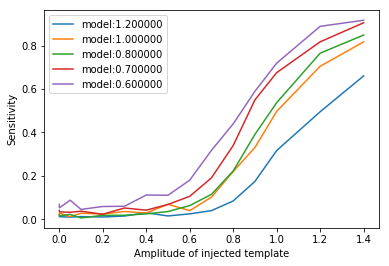

In [11]:
###
###  Testing...
###

with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
    sess.run(tf.global_variables_initializer())

    ### Testing
    TEST_LIST = [1.4, 1.2, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.001, 0.0]

    plt.figure()
    for m in  [1.2, 1.0, 0.8, 0.7, 0.6]:
        load_path = saver.restore(sess, "%s/model_%3.1f.ckpt" % (ROOT_FOLDER, m ) )
        print("Model restored from %s" % load_path )

        #gacc=[]
        gsen=[]
        for amplitude in TEST_LIST:
            sess.run(tf.local_variables_initializer())


            #Xts, Yts  = GWdata.get_test_set(A=amplitude)
            Xts, Yts   = GWdata.get_shifted_test_set(A=amplitude, shift=2500)  

            sess.run(test_init_op, feed_dict={ x: Xts, y: Yts, bs:1024 })

            pre, loss, acc, sen, ttp, ttn, tfp, tfn = sess.run([predict_prob, loss_op, accuracy, sensitivity, tp, tn, fp, fn ])
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : loss: %9.3f Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (amplitude, loss, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    plt.show()


In [14]:
##
##  Re-training with shifted waveform....
##
STEPS=8000
BATCH = 128
EPOCHS = 1
MONITOR=200

GWdata = GWInject("white_h_fixed.h5")

###
ROOT_FOLDER = '/tmp/tf_tmp'
saver = tf.train.Saver()


with tf.Session() as sess:
   
    ###
    merged = tf.summary.merge_all()
    
    train_writer = tf.summary.FileWriter(ROOT_FOLDER + '/train')
    train_writer.add_graph(tf.get_default_graph())
    print('Saving graph to: %s' % ROOT_FOLDER)
    
    
    sess.run(tf.global_variables_initializer())

    load_path = saver.restore(sess, "%s/model_%3.1f.ckpt" % (ROOT_FOLDER, 0.6 ) )
    print("Model restored from %s" % load_path )
    
    ##for amplitude in [1.2, 1.0, 0.8, 0.6, 0.5, 0.4, 0.3, 0.2]:
    for amplitude in [1.2, 1.0, 0.8, 0.7, 0.6]:
        sess.run(tf.local_variables_initializer())

        print("Trainning for A= %f"% amplitude)
        Xt, Xv, Yt, Yv = GWdata.get_shifted_train_val_set(A=amplitude, shift=0)

        sess.run(train_init_op, feed_dict={ x:Xt, y:Yt, bs:BATCH})
        
        for e in range(EPOCHS):
            time0 = time.time()
            for i in range(STEPS):
                #optimizer.run()
                _, summary, loss, acc, sen = sess.run( [optimizer, merged, loss_op, accuracy, sensitivity] )   ## 
                train_writer.add_summary(summary)

                if i % MONITOR == 0:
                    #_, loss, acc, sen = sess.run( [optimizer, loss_op, accuracy, sensitivity] )   ## 

                    time1 = time.time()
                    duration = time1 - time0
                    speed = MONITOR * BATCH / duration
                    time0 = time1
                    print('  step: %5d, loss: %10.3e accuracy: %6.3g sec: %6.3g speed: %8.1f wf/sec' % (i, loss, acc, sen, speed))
                    if loss < 1e-6:
                        break
            
        save_path = saver.save(sess, "%s/model_%3.1f.ckpt" % (ROOT_FOLDER, amplitude ) )
        print("Model saved at %s" % save_path)


Saving graph to: /tmp/tf_tmp
INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_0.6.ckpt
Model restored from None
Trainning for A= 1.200000
  step:     0, loss:  1.114e+00 accuracy:  0.969 sec:      1 speed:  66723.0 wf/sec
  step:   200, loss:  0.000e+00 accuracy:      1 sec:      1 speed:   3236.2 wf/sec
Model saved at /tmp/tf_tmp/model_1.2.ckpt
Trainning for A= 1.000000
  step:     0, loss:  8.925e-01 accuracy:  0.984 sec:  0.966 speed: 117480.2 wf/sec
  step:   200, loss:  1.678e-36 accuracy:  0.996 sec:  0.996 speed:   3273.4 wf/sec
Model saved at /tmp/tf_tmp/model_1.0.ckpt
Trainning for A= 0.800000
  step:     0, loss:  1.175e+01 accuracy:  0.852 sec:   0.71 speed: 114423.2 wf/sec
  step:   200, loss:  1.007e+00 accuracy:  0.935 sec:  0.935 speed:   3265.6 wf/sec
  step:   400, loss:  5.294e-01 accuracy:  0.953 sec:  0.953 speed:   3237.8 wf/sec
  step:   600, loss:  2.620e-01 accuracy:  0.964 sec:  0.964 speed:   3208.2 wf/sec
  step:   800, loss:  1.254e-05 accuracy:  

INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_1.2.ckpt
Model restored from None
Test for A= 1.40 : loss:    36.896 Acc:     0.834, Sen:     0.675, TP/TN/FP/FN:   353   501     0   170 
Test for A= 1.20 : loss:    66.470 Acc:     0.729, Sen:     0.453, TP/TN/FP/FN:   230   516     0   278 
Test for A= 1.00 : loss:   104.988 Acc:     0.630, Sen:     0.252, TP/TN/FP/FN:   128   517     0   379 
Test for A= 0.90 : loss:   133.330 Acc:     0.569, Sen:     0.127, TP/TN/FP/FN:    64   519     0   441 
Test for A= 0.80 : loss:   166.937 Acc:     0.514, Sen:     0.033, TP/TN/FP/FN:    17   509     0   498 
Test for A= 0.70 : loss:   184.533 Acc:     0.518, Sen:     0.000, TP/TN/FP/FN:     0   530     0   494 
Test for A= 0.60 : loss:   205.457 Acc:     0.512, Sen:     0.000, TP/TN/FP/FN:     0   524     0   500 
Test for A= 0.50 : loss:   219.537 Acc:     0.513, Sen:     0.000, TP/TN/FP/FN:     0   525     0   499 
Test for A= 0.40 : loss:   222.870 Acc:     0.508, Sen:     0.000,

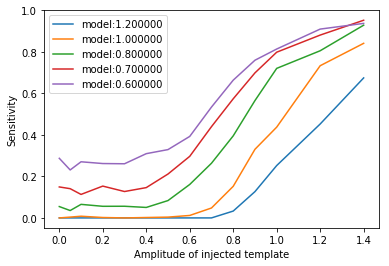

In [15]:
###
###  Testing again with model trained by time-shifted data ...
###

with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
    sess.run(tf.global_variables_initializer())

    ### Testing
    TEST_LIST = [1.4, 1.2, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.0]

    plt.figure()
    for m in  [1.2, 1.0, 0.8, 0.7, 0.6]:
        load_path = saver.restore(sess, "%s/model_%3.1f.ckpt" % (ROOT_FOLDER, m ) )
        print("Model restored from %s" % load_path )

        #gacc=[]
        gsen=[]
        for amplitude in TEST_LIST:
            sess.run(tf.local_variables_initializer())


            #Xts, Yts  = GWdata.get_test_set(A=amplitude)
            Xts, Yts   = GWdata.get_shifted_test_set(A=amplitude, shift=2500)  

            sess.run(test_init_op, feed_dict={ x: Xts, y: Yts, bs:1024 })

            pre, loss, acc, sen, ttp, ttn, tfp, tfn = sess.run([predict_prob, loss_op, accuracy, sensitivity, tp, tn, fp, fn ])
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : loss: %9.3f Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (amplitude, loss, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    plt.show()
